In [1]:
from IPython.display import display
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys

from misc import rename_cytokines, rename_CMs, rename_bloods, rename_factors, rename_factor, rename_Y, make_annot, convert_partial_year, rename_pathways
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8
LGD_MARKER_SCALE = 1.2

FDR = [0.05]
ATAC_FDR = [0.1]
VOLCANO_MAX_ANNOT = 20
CELL_SIZE = 0.25
LM_VMAX = 5
LM_VMIN = -1 * LM_VMAX
ENR_VMAX = 7
ENR_VMIN = -1 * ENR_VMAX
AGE_EFFECT_PER_N_YEARS = 10
PVAL_ASTERISKS = [0.05, 0.01, 0.001]

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure2')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'

EXCLUDE = r'C\.albicans\.yeast_24h_PBMC_IFNg|lactate'

# Suppl. Tables

In [3]:
SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([IMMUNE_ANALYSIS], modes=['a'])

BCG V1 age: 18.204343689466587 71.91934125957413
BCG V1 sex: F M
BCG V1 BMI: 17.8359096313912 34.23494794024446
BCG V1 oral contraceptives: False True
BCG V1 alcohol: False True
BCG V1 timespan: 08:00:00 12:15:00
BCG vax timespan: 08:05:00 18:30:00


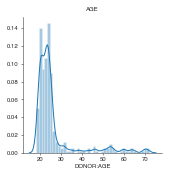

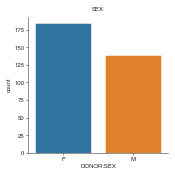

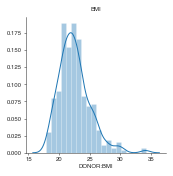

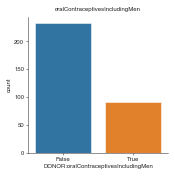

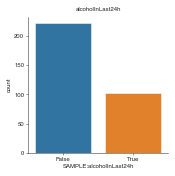

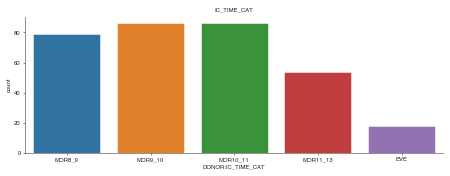

MOR8_9 79
MOR9_10 86
MOR10_11 86
MOR11_13 54
EVE 18

Missing IC_TIME_CAT:


Series([], Name: DONOR:IC_TIME, dtype: object)


After noon:


SAMPLE:ID
300BCG043_V1_PBMC    12:00:00
300BCG061_V1_PBMC    12:05:00
300BCG129_V1_PBMC    12:15:00
300BCG279_V1_PBMC    12:08:00
Name: DONOR:IC_TIME, dtype: object

In [4]:
df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:VISIT'] == 'V1') & (df['SAMPLE:TISSUE'] == 'PBMC') & df['SAMPLE:EXCLUSION'].isnull() & ~df['SAMPLE:VISIT_TIME'].isnull()]
print('BCG V1 age:', df['DONOR:AGE'].min(), df['DONOR:AGE'].max())
print('BCG V1 sex:', df['DONOR:SEX'].min(), df['DONOR:SEX'].max())
print('BCG V1 BMI:', df['DONOR:BMI'].min(), df['DONOR:BMI'].max())
print('BCG V1 oral contraceptives:', df['DONOR:oralContraceptivesIncludingMen'].min(), df['DONOR:oralContraceptivesIncludingMen'].max())
print('BCG V1 alcohol:', df['SAMPLE:alcoholInLast24h'].min(), df['SAMPLE:alcoholInLast24h'].max())
print('BCG V1 timespan:', df['SAMPLE:VISIT_TIME'].min(), df['SAMPLE:VISIT_TIME'].max())
print('BCG vax timespan:', df['DONOR:IC_TIME'].min(), df['DONOR:IC_TIME'].max())

_, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
ax = sns.distplot(df['DONOR:AGE'])
ax.set_title('AGE')
sns.despine()
plt.show()

_, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
ax = sns.countplot(df['DONOR:SEX'])
ax.set_title('SEX')
sns.despine()
plt.show()

_, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
ax = sns.distplot(df['DONOR:BMI'])
ax.set_title('BMI')
sns.despine()
plt.show()

_, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
ax = sns.countplot(df['DONOR:oralContraceptivesIncludingMen'])
ax.set_title('oralContraceptivesIncludingMen')
sns.despine()
plt.show()

_, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
ax = sns.countplot(df['SAMPLE:alcoholInLast24h'])
ax.set_title('alcoholInLast24h')
sns.despine()
plt.show()

_, ax = plt.subplots(figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1] * 2))
ax = sns.countplot(df['DONOR:IC_TIME_CAT'])
ax.set_title('IC_TIME_CAT')
sns.despine()
plt.show()

for time_win in ['MOR8_9', 'MOR9_10', 'MOR10_11', 'MOR11_13', 'EVE']:
    print(time_win, (df['DONOR:IC_TIME_CAT'] == time_win).sum())
    
print('\nMissing IC_TIME_CAT:')
display(df[df['DONOR:IC_TIME_CAT'].isnull()]['DONOR:IC_TIME'])

print('\nAfter noon:')
display(df.loc[df['DONOR:IC_TIME'].str.contains('^12|^13|^14|^15|^16|^17'), 'DONOR:IC_TIME'])

In [5]:
LMM = True
across_donors_df = []
for Y_name in ['WB_PER_ML', 'CM', 'CYTO']:
    model = '{}.{}'.format(Y_name, 'BLOOD' if Y_name == 'CYTO' else 'WHOLE_BLOOD' if Y_name == 'CM' else None)
    var_df = pd.read_csv(os.path.join('results', 'LR', '{}.varCorrBlood.{}'.format(CELLTYPE, model),
                                  'LR_variance_{}.None.steady_state{}.csv'.format(Y_name, '.LMM' if LMM else None)), index_col=['target', 'contrast'])
    if Y_name == 'CYTO':
        var_df = var_df.loc[~var_df.index.get_level_values('target').str.contains(EXCLUDE)]
    var_df = var_df.sort_index()
    var_df = var_df[['FVE']].reset_index().set_index('target')
    var_df['contrast'] = var_df['contrast'].apply(lambda x: 'Across-donor' if x == 'SAMPLE_DONOR' else 'Within-donor' if x == 'Residual' else x)
    var_df['FVE'] *= 100
    print(var_df.loc[var_df['contrast'] == 'Across-donor', 'FVE'].sort_values(ascending=False).head(3))
    across_donors_df.append(var_df.loc[var_df['contrast'] == 'Across-donor'].copy())
    across_donors_df[-1]['modality'] = Y_name
    
    if SAVE_TABLES:
        suppl_df = misc.suppl_table_immune_donor_var(var_df, Y_name, suppl_tables, table_name=IMMUNE_ANALYSIS)
        display(suppl_df.head())

target
WB_PER_ML:NKT      78.455312
WB_PER_ML:NK       67.841533
WB_PER_ML:T/CD8    65.642250
Name: FVE, dtype: float64


,FVE
Cell type,
B cells (CD19+),0.649052
Monocytes (CD14++CD16+),0.421155
Monocytes (CD14++CD16−),0.407175
Monocytes (CD14+CD16+),0.469317
Neutrophils,0.452764


target
CM:IL.10RA_Q13651    89.697163
CM:CST5_P28325       86.674375
CM:CCL25_O15444      86.520330
Name: FVE, dtype: float64


,FVE
Inflammatory marker,
4E-BP1,0.268092
ADA,0.757432
Axin-1,0.338899
CASP-8,0.395928
CCL11,0.801463


target
CYTO:C.albicans.yeast_24h_PBMC_IL.1b_good    73.164249
CYTO:C.albicans.yeast_24h_PBMC_MIP1b_good    72.594987
CYTO:C.albicans.yeast_24h_PBMC_IL.6_good     69.376427
Name: FVE, dtype: float64


,FVE
Cytokine,
"CCL3 (Ca, 24h)",0.639526
"CCL3 (Mt, 24h)",0.424868
"CCL4 (Ca, 24h)",0.725950
"CCL4 (Mt, 24h)",0.474961
"CXCL10 (Ca, 24h)",0.570725


,contrast,FVE,modality
WB_PER_ML:B,Across-donor,64.905201,Immnune cell frequencies
WB_PER_ML:MONO/CLASSICAL,Across-donor,40.717488,Immnune cell frequencies
WB_PER_ML:MONO/INTERMEDIATE,Across-donor,46.931690,Immnune cell frequencies
WB_PER_ML:MONO/NON_CLASSICAL,Across-donor,42.115503,Immnune cell frequencies
WB_PER_ML:NEUTRO,Across-donor,45.276445,Immnune cell frequencies


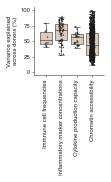

In [6]:
ATAC_HIGH_VAR_N = 1000
atac_across_donors_df = pd.read_csv(os.path.join(fig_dir, 'ATACseq_expl_var_blood_corr.{}.highVar{}.csv'.format('LMM' if LMM else 'fixedEffects', ATAC_HIGH_VAR_N)), index_col=0)
across_donors_df.append(atac_across_donors_df)
across_donors_df = pd.concat(across_donors_df, axis=0)
across_donors_df['modality'] = across_donors_df['modality'].map({
    'WB_PER_ML': 'Immnune cell frequencies',
    'CM': 'Inflammatory marker concentrations',
    'CYTO': 'Cytokine production capacity',
    'ATAC': 'Chromatin accessibility',
})
display(across_donors_df.head())

assert len(across_donors_df['contrast'].unique()) == 1
misc.FVE_boxplot(across_donors_df, x='modality', y_label='Variance explained\n{}s (%)'.format(across_donors_df['contrast'].unique()[0].lower().replace('-', ' ')),
                 palette=[LIGHT_BROWN], figsize=(FIG_SIZE[0], FIG_SIZE[1]), alpha=ALPHA, jitter=0.15, rasterized=RASTER)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'expl_var_blood_corr.{}.svg'.format('LMM' if LMM else 'fixedEffects')), dpi=DPI)
plt.show()

# Boxplots for supplement

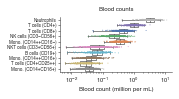

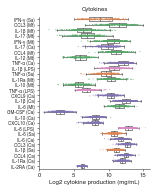

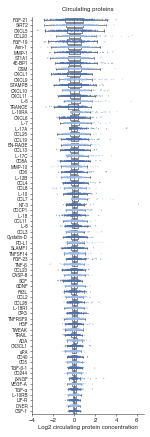

In [7]:
df = misc.get_sample_annot()
df = df.loc[(df['SAMPLE:TISSUE'] == 'PBMC') & (df['SAMPLE:VISIT'] == 'V1')]
df.loc[:, df.columns.str.contains('^PBMC_PERC:|^WB_PERC:')] /= 100
WB_CELLTYPES = [
    'WB_PER_ML:MONO/CLASSICAL',
    'WB_PER_ML:MONO/INTERMEDIATE',
    'WB_PER_ML:MONO/NON_CLASSICAL',
    'WB_PER_ML:T/CD8',
    'WB_PER_ML:T/CD4',
    'WB_PER_ML:T/CD4/TREG',
    'WB_PER_ML:B',
    'WB_PER_ML:NK',
    'WB_PER_ML:NKT',
    'WB_PER_ML:NEUTRO'
]

CYTOKINES = df.columns[df.columns.str.contains('^CYTO:.*_good$') & ~df.columns.str.contains('lactate')].values

CMS = df.columns[df.columns.str.contains('^CM:')].values

for cols, Y_name, xlabel, log_scale, centre, palette in [
    (WB_CELLTYPES, 'Blood counts', 'Blood count (million per mL)', True, False,
     [LIGHT_GRAY, PURPLE, BLUE, GREEN, ORANGE, PINK, CYAN, BROWN, YELLOW, GRAY]),
    (CYTOKINES, 'Cytokines', 'Log2 cytokine production (mg/mL)', False, False, None),
    (CMS, 'Circulating proteins', 'Log2 circulating protein concentration', False, True, None),
]:
    _df = df[cols]
    _df = _df[_df.std().sort_values(ascending=False).index]
    
    if 'blood' in xlabel.lower():
        _df.columns = rename_bloods(_df.columns.str.split(':', expand=True).get_level_values(1), plural=True, drop_cell_suffix=False, short_mono=True, capitalize=True)

    elif 'cytokine' in xlabel.lower():
        palette = misc.rename_cytokines(_df.columns, only_stimulus=True)
        palette = palette.astype(object)
        palette[palette == 'Ca'] = PURPLE
        palette[palette == 'LPS'] = PINK
        palette[palette == 'Mt'] = GREEN
        palette[palette == 'Sa'] = ORANGE
#         cytokines = misc.rename_cytokines(_df.columns, only_cyto=True)
        _df.columns = rename_cytokines(_df.columns)
    elif 'circulating' in xlabel.lower():
        palette = [BLUE, LIGHT_BLUE] * int(np.ceil(df.shape[1] / 2))
        _df.columns = rename_CMs(_df.columns)
    
    if centre:
        _df -= _df.median(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(2, 0.1 * _df.shape[1]))
    ax = sns.boxplot(data=_df, orient='h', fliersize=0)
    ax = utils.stripplot(data=_df, orient='h', s=1, alpha=ALPHA, palette=palette, rasterized=RASTER, random_state=misc.RANDOM_STATE)
#     if 'cytokine' in xlabel.lower():
#         ax.set_yticklabels(cytokines)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=SMALL_FONT)
    plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=0.5)
    plt.setp(ax.lines, color='k', lw=0.5)
    if log_scale:
        ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_title(rename_Y(Y_name, caps=True, plural=True))
    sns.despine()
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'S2_{}.distribution_V1.svg'.format(Y_name)), dpi=DPI)
    plt.show()


----------------
V I S I T --- V1
----------------
results/LR/PBMC.final.CYTO.None//LR_results_CYTO.V1.steady_state.include_blood_perc.csv


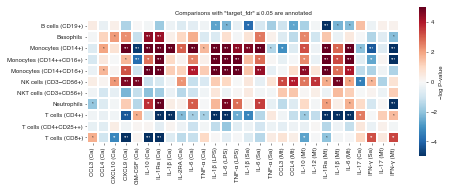

,,Coefficient,T-value,P-value,Adjusted P-value
Cytokine,Cell type,,,,
"IL-1Ra (Ca, 24h)",Monocytes (CD14+),0.051401,15.210714,2.654168e-39,7.431672e-38
"IL-1Ra (Mt, 24h)",Monocytes (CD14+),0.062202,7.417679,1.405385e-12,1.538389e-11
"IL-1β (Ca, 24h)",Monocytes (CD14+),0.052044,7.365512,1.648274e-12,1.538389e-11
"IL-10 (Ca, 24h)",Monocytes (CD14+),0.044435,7.073782,1.030270e-11,7.211889e-11
"IL-6 (Mt, 24h)",T cells (CD4+),-0.050917,-6.954786,2.462410e-11,6.894748e-10



----------------
V I S I T --- V1
----------------
results/LR/PBMC.final.CYTO.None//LR_results_CYTO.V1.steady_state.include_blood_perc.csv


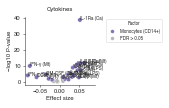


----------------
V I S I T --- V1
----------------
results/LR/PBMC.final.CYTO.None//LR_results_CYTO.V1.steady_state.include_blood_perc.csv


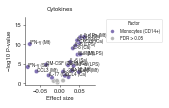


----------------
V I S I T --- V1
----------------
results/LR/PBMC.final.WB_PER_ML.None//LR_results_WB_PER_ML.V1.steady_state.csv


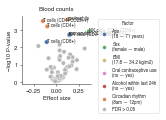

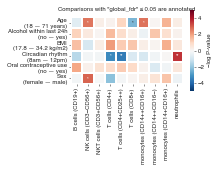

,,Coefficient,T-value,P-value,Adjusted P-value
Cell type,Host factor,,,,
Neutrophils,Sample-collection time,0.121797,3.702439,0.000252,0.009265
T cells (CD4+CD25++),Sample-collection time,-0.149080,-3.648184,0.000309,0.009265
T cells (CD4+),Sample-collection time,-0.101388,-3.452909,0.000630,0.012603
NK cells (CD3−CD56+),Sex,0.356358,3.263024,0.001223,0.018344
Monocytes (CD14++CD16+),Age,0.014261,3.134178,0.001885,0.020369



----------------
V I S I T --- V1
----------------
results/LR/PBMC.final.CM.WHOLE_BLOOD//LR_results_CM.V1.steady_state.csv


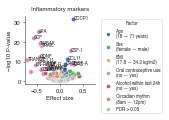

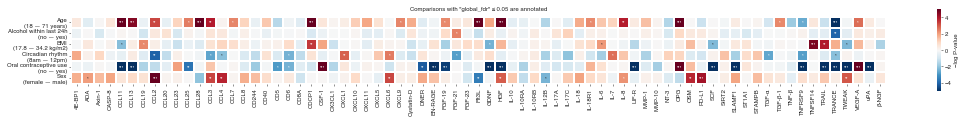

,,Coefficient,T-value,P-value,Adjusted P-value
Inflammatory marker,Host factor,,,,
CDCP1,Age,0.029948,13.323544,3.422964e-32,1.499258e-29
uPA,Oral contraceptives,-0.455648,-11.541649,8.709270e-26,1.907330e-23
SCF,Oral contraceptives,-0.562746,-10.623867,1.280387e-22,1.869365e-20
TWEAK,Oral contraceptives,-0.422911,-9.788562,7.720686e-20,8.454151e-18
TRAIL,Oral contraceptives,-0.395161,-9.452328,9.441453e-19,8.270713e-17



----------------
V I S I T --- V1
----------------
results/LR/PBMC.final.CYTO.BLOOD//LR_results_CYTO.V1.steady_state.csv


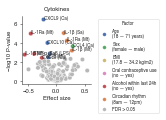

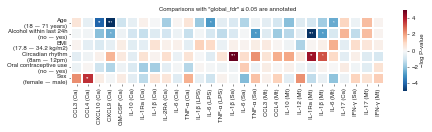

Coefficient   T-value       P-value  \
Cytokine         Host factor                                                   
CXCL9 (Ca, 24h)  Age                       -0.022877 -5.196371  3.799414e-07   
IL-1β (Sa, 24h)  Sample-collection time     0.129476  4.502971  9.627316e-06   
IL-1Ra (Mt, 24h) Alcohol                   -0.454759 -4.480155  1.099428e-05   
                 Sample-collection time     0.185549  4.077605  5.979948e-05   
CXCL10 (Ca, 24h) Age                       -0.015933 -3.942092  1.010870e-04   

                                         Adjusted P-value  
Cytokine         Host factor                               
CXCL9 (Ca, 24h)  Age                             0.000064  
IL-1β (Sa, 24h)  Sample-collection time          0.000616  
IL-1Ra (Mt, 24h) Alcohol                         0.000616  
                 Sample-collection time          0.002512  
CXCL10 (Ca, 24h) Age                             0.003397

In [8]:
SCAR_FACTORS = ['DONOR:scarSize_v3']  # 'DONOR:sizeOfVaccinationSpot_v2'
HOST_FACTORS = ['SAMPLE:VISIT_TIME_REAL', 'DONOR:AGE', 'DONOR:BMI', 'DONOR:SEX', 'DONOR:oralContraceptivesIncludingMen', 'SAMPLE:alcoholInLast24h']
FACTORS_ORDER = ['Age', 'Sex', 'BMI', 'Oral\ncontrac.', 'Alcohol', 'Circadian\nrhythm']
EXPLAIN_FACTORS_ORDER = ['{}{}'.format(s[0].upper(), s[1:]) for s in misc.RENAME_FACTOR_EXPLAIN.values()]

for (visits, visit_interaction, fold_changes, LMM, remove_evening) in [
        (['V1'], None, None, False, False),
]:
    for model_prefix, joint_volcano, show_heatmap, Y_name, blood, annot_col, factors_kind, subset_factors, factors_order, explain_factors, palette, exclude_targets, ylim, remove_evening, make_suppl_table, fig_n in [
        # cytokines and immune cell fractions
        ('final', False, True, 'CYTO', None, 'target_fdr', 'include_blood_perc', None, None, False, [PURPLE], EXCLUDE, None, False, True, 'S2E'),
        ('final', True, False, 'CYTO', None, 'target_fdr', 'include_blood_perc', 'PBMC_PERC:MONO', ['Monocytes (CD14+)'], False, [PURPLE], EXCLUDE, None, False, False, None),
        ('final', True, False, 'CYTO', None, 'target_fdr', 'include_blood_perc', 'PBMC_PERC:MONO', ['Monocytes (CD14+)'], False, [PURPLE], EXCLUDE + '|C\.albicans\.yeast_24h_PBMC_IL.1ra', 17, False, False, None),
        # host factors
        ('final', True, True, 'WB_PER_ML', None, 'global_fdr', None, HOST_FACTORS, EXPLAIN_FACTORS_ORDER, True, [BLUE, GREEN, YELLOW, PINK, RED, ORANGE], None, None, False, True, '2B'),
        ('final', True, True, 'CM', 'WHOLE_BLOOD', 'global_fdr', None, HOST_FACTORS, EXPLAIN_FACTORS_ORDER, True, [BLUE, GREEN, YELLOW, PINK, RED, ORANGE], None, None, False, True, '2C'),
        ('final', True, True, 'CYTO', 'BLOOD', 'global_fdr', None, HOST_FACTORS, EXPLAIN_FACTORS_ORDER, True, [BLUE, GREEN, YELLOW, PINK, RED, ORANGE], EXCLUDE, None, True, True, '2D'),
#          This is dones with the LMM model in Figure 5 now (even for baseline):        
#         ('scar', False, True, 'CYTO', 'BLOOD', 'global_fdr', None, SCAR_FACTORS, None, False, None, EXCLUDE, None, True, False),
    ]:
        res_df, pvals_df, joint_df, de_df = misc.factor_analysis(
            celltype=CELLTYPE, model='{}.{}.{}'.format(model_prefix, Y_name, blood), Y_name=Y_name, factors_kind=factors_kind,
            subset_factors=subset_factors, exclude_targets=exclude_targets, annot_col=annot_col,
            visits=visits, visit_interaction=visit_interaction, fold_changes=fold_changes, LMM=LMM, scale=False, remove_evening=remove_evening,
            factor_volcanos=False, joint_volcano=joint_volcano, heatmap=show_heatmap, fdr=FDR,
            age_effect_per_N_years=AGE_EFFECT_PER_N_YEARS,
            scatter_kws=dict(linewidth=CIRCLE_LINE_WIDTH),
            legend_kws=dict(bbox_to_anchor=(2, 1), title='Factor',
                            ncol=len(HOST_FACTORS) + 1 if False and subset_factors else 1,
                            markerscale=1, fontsize=SMALL_FONT),
            volcano_kws=dict(size=CIRCLE_SIZE, alpha=None, figsize=FIG_SIZE, rasterized=False,
                             sharex=False, sharey=False, xlabel='Effect size', fdr_with_hue=True,
                             fdr_pass_color=BLUE,
                             hue_order=factors_order, auto_sort=True,
                             palette=palette,
                             fdr_fail_color=LIGHT_GRAY, fdr_prefix='FDR ', ylim=ylim),
            factor_rename_kws=dict(multiline=True, short_rhythm=False, short_contraceptives=True, explain_factors=explain_factors),
            annot_kws={},
            cbar_kws={},
            heatmap_kws=dict(vmin=LM_VMIN, vmax=LM_VMAX),
            annot_size=SMALL_FONT, max_annot=VOLCANO_MAX_ANNOT,
            cell_width=CELL_SIZE, cell_height=CELL_SIZE, names_without_time=False, names_without_stimulus=False, blank_no_significance=False,
            pval_asterisks=PVAL_ASTERISKS, pval_fmt='.0e',
            cbar_label='{}log P-value'.format(utils.MINUS),
            padj_method='fdr_bh', fig_dir=fig_dir, save_fig=SAVE_FIG, show_fig=True,
            fig_format=dict(pvals_heatmap='pdf', volcanos='pdf', joint_volcano='svg'), dpi=DPI)
        if make_suppl_table and SAVE_TABLES:
            suppl_df = misc.suppl_table_immune_d0_host_factors(res_df, Y_name, factors_kind, suppl_tables=suppl_tables, table_name=IMMUNE_ANALYSIS, fig_n=fig_n)
            display(suppl_df.sort_values(PVAL_COL).head())

In [9]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S02_immune_functions


,Contents
Sheet name,
cellFreq_corr,Pairwise Spearman correlations of frequencies ...
inflaMark_corr,Pairwise Spearman correlations of 73 circulati...
cytokine_corr,Pairwise Spearman correlations of 28 ex vivo c...
cellFreq_donorVar,Fraction of variance explained (FVE) by donor ...
inflaMark_donorVar,Fraction of variance explained (FVE) by donor ...
cytokine_donorVar,Fraction of variance explained (FVE) by donor ...
cytokine_d0_cellFreq,Association of cytokine production capacity wi...
cellFreq_d0_hostFactors,Association of immune cell frequencies with ho...
inflaMark_d0_hostFactors,Association of inflammatory marker concentrati...


In [10]:
misc.fix_font_for_suppl_tables(suppl_tables)